In [30]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
#import import_ipynb
import seaborn as sns
%matplotlib inline

In [31]:
import os
cwd = os.getcwd()
cwd

'D:\\0Studia\\praca-licencjacka-euk\\kod-python'

In [32]:
sales_data = pd.read_csv("D:\\MM\\lic-uek-dane\\train.csv")[:144]#first store and first department
features_data = pd.read_csv("D:\\MM\\lic-uek-dane\\features.csv")[:143]
figure_path = "..\\figures\\"

In [33]:
#m - numer of equations
#T - number of observations
#k - number of exogenous variables 

In [34]:
t = 143 #number of observations
sales_data = pd.read_csv("D:\\MM\\lic-uek-dane\\train.csv")[:10244]
d38 = sales_data[sales_data["Dept"] == 38]
d40 = sales_data[sales_data["Dept"] == 40]
holidays = features_data["IsHoliday"]

TRAIN_SIZE = 104
TEST_SIZE = t - TRAIN_SIZE
x1, x2 = d38["Weekly_Sales"].values / 1000, d40["Weekly_Sales"].values / 1000
holidays = holidays.values
x1x2 = x1 * x2
x1_kw = x1 * x1 
x2_kw = x2 * x2
endog = pd.DataFrame({"Prescription Pharmacy": x1, "OTC Pharmacy": x2},
                columns = ["Prescription Pharmacy", "OTC Pharmacy"])

endog_train = endog.iloc[:TRAIN_SIZE,:]
endog_test = endog.iloc[TRAIN_SIZE:,:]



second_order = pd.DataFrame([x1_kw, x2_kw, x1x2]).T
second_order.columns = ["Prescription^2", "OTC^2", "Prescription*OTC"]

months_onehot = np.zeros(shape = (143, 12))#january will be (later on) the reference month
dates = d40["Date"].values
months = [int(dates[i][5:7])  if dates[i][5:7][0] != str(0) else int(dates[i][6]) for i in range(len(dates))]
for i in range(143):
    months_onehot[i, months[i]-1] = 1

#in order to avoid collinearity first column will be removed
months_onehot = np.delete(months_onehot, obj = 0, axis = 1) #axis = 1 means column

yp = x1[4:]
yo = x2[4:]
const = np.ones(shape = (t-4))
xp1 = x1[3:-1]
xp2 = x1[2:-2]
xp3 = x1[1:-3]
xp4 = x1[:-4]
xo1 = x2[3:-1]
xo2 = x2[2:-2]
xo3 = x2[1:-3]
xo4 = x2[:-4]
X1 = np.array([const, xp1, xp2, xp3, xp4, xo1, xo2, xo3, xo4]).T
X2 = np.concatenate((np.concatenate((np.array([const, holidays[4:]]).T, months_onehot[4:,]), axis = 1), 
                     np.array([x1_kw[:-4], x1x2[:-4], x2_kw[:-4],
                    xp1, xo1, xp2, xo2, xp3, xo3, xp4, xo4]).T), axis = 1)

In [35]:
#class for VAR models with 2 equations

class VAR():
    def __init__(self, y1, X1, y2, X2, T, colnames1, colnames2):
        self.y1 = y1
        self.X1 = X1
        self.y2 = y2
        self.X2 = X2
        self.T = T
        self.colnames1 = colnames1
        self.colnames2 = colnames2
        #data is stored in format: [(y1, X1), (y2, X2)] y-endog variable x-exog variables (also lagged y's)
    
    def OLS(self, X, y):
        return np.linalg.inv(X.T @ X) @ X.T @ y
    def LM_prediction(self, b_hat, X):
        return X @ b_hat
    def RSS(self, y, e):
        return np.sum((y - e) ** 2) / len(y)
        
    def Simple_sigma_est(self):
        S = np.zeros(shape = (2,2))
        res1 = self.y1 - self.LM_prediction(self.OLS(self.X1, self.y1), self.X1)
        res2 = self.y2 - self.LM_prediction(self.OLS(self.X2, self.y2), self.X2)
        S[0,0] = sum(res1 * res1) / self.T
        S[0, 1] = sum(res1 * res2) / self.T
        S[1, 0] = S[0, 1]
        S[1, 1] = sum(res2 * res2) / self.T
        return S
        
    #fits the Zellner estimator to the given model, returns the estimated beta parameters with it's variance (matrix)
    def Zellner_fit(self, Sigma):
        k1 = self.X1.shape[1]
        k2 = self.X2.shape[1]
        #y_z is a vector containing explanatory variables for each eqation in form [y1, y2, y3, ..., ym] (dim T*m x 1)
        y_z = np.concatenate((self.y1, self.y2), axis = 0)
        #X_z is a block matrix with blocks on diagonal equal to X_i matrix for i-th equation for VAR model
        X_z = np.block([  [self.X1,                         np.zeros(shape = (self.T, k2))], 
                          [np.zeros(shape = (self.T, k1)),                         self.X2]
                       ])
        Sinv_kron_I = np.kron(np.linalg.inv(Sigma), np.eye(self.T))

        #Zellner estimator for beta parameters (for all equations) and (asymptotic) variance of this estimator
        B_hat = np.linalg.inv(X_z.T @ Sinv_kron_I @ X_z) @ X_z.T @ Sinv_kron_I @ y_z
        Var_B = np.linalg.inv(X_z.T @ Sinv_kron_I @ X_z)
        return B_hat, Var_B
    
    #iterated zellner estimator, it is equivalent to MLE or Iterated Feasible Generalize Least Squares (IFGLS) Estimator
    def iterated_Zellner(self, stop_condition = 1e-3, max_iter = 10):
        n_iter = 0
        sigma = self.Simple_sigma_est()
        B_hat, Var_B = self.Zellner_fit(sigma)
        
        while n_iter < max_iter and stop_condition:
            res, y_hat = self.residuals(B_hat)
            S = np.zeros(shape = (2,2))
            res1 = res[:self.T]
            res2 = res[self.T:]
            S[0,0] = sum(res1 * res1) / self.T
            S[0, 1] = sum(res1 * res2) / self.T
            S[1, 0] = S[0, 1]
            S[1, 1] = sum(res2 * res2) / self.T
            iter_beta, Var_B = self.Zellner_fit(S)
            
            #for how many params stop condition is not fulfilled (we want this number to be 0)
            how_many = abs((iter_beta - B_hat)/B_hat) > stop_condition
            
            if np.sum(how_many) == 0:
                stop_condition = 0#this will break the loop
            
            n_iter += 1#loop counter
            sigma = S#update the sigma
            B_hat = iter_beta#update the beta parameters
        
        print("number of loops:", n_iter)
        return B_hat, Var_B, sigma
    
    #produces t-test statistics and pvalues for all variables 
    def variables_importance(self, b_hat, var_b):
        k = b_hat.shape[0]
        t_stat = np.array([b_hat[i] / var_b[i,i]**0.5 for i in range(k)])
        pvalues = 2 * (1 - stats.t.cdf(abs(t_stat), df = self.T - k))
        return t_stat, pvalues
    
    def residuals(self, beta):
        k1 = self.X1.shape[1]
        y_hat = np.concatenate((self.X1 @ beta[:k1], self.X2 @ beta[k1:]))
        res = np.concatenate((self.y1, self.y2), axis = 0) - y_hat
        return res, y_hat
    
    
    def llf(self, beta, sigma):
        K = 2 #nuber of equations
        k1 = self.X1.shape[1]
        y_z = np.concatenate((self.y1, self.y2), axis = 0)
        location =  np.concatenate((self.X1 @ beta[:k1], self.X2 @ beta[k1:]), axis = 0)#alternatively: X_z @ beta
        return np.sum([stats.multivariate_normal.logpdf(y_z[[i,i+self.T]],
                                                        location[[i,i+self.T]], sigma) for i in range(self.T)])
    
    
    #function to reduce the model based on some criterion, it will reduce the model untill the critetion will 
    #be fulfilled, also plotting option was added
    def reduction(self, criterion = 0.05,  plot = True, save_plot_as = False):
        original_names = self.colnames1.copy()
        sigma = self.Simple_sigma_est()
        b_hat, var_b = self.Zellner_fit(sigma)
        t_stat, pvalues = self.variables_importance(b_hat ,var_b)
        counter = 0
        
        while max(pvalues) > criterion:
            k1 = self.X1.shape[1]
            k2 = self.X2.shape[1]
            remove_index = pvalues.argmax()
            counter += 1
            
            #we have to choose from which matrix we will remove a variable
            if remove_index >= k1:
                print("Usuwamy", "\"" + self.colnames2[remove_index - k1] + "\"" , "pvalue =", str(round(max(pvalues), 2)),
                     "(OTC)")
                self.X2 = np.delete(self.X2, remove_index - k1, axis = 1)
                self.colnames2.pop(remove_index - k1)
            else:
                print("Usuwamy", "\"" + self.colnames1[remove_index] + "\"" , "pvalue =", str(round(max(pvalues), 2)),
                      "(Prescription)")
                self.X1 = np.delete(self.X1, remove_index, axis = 1)
                self.colnames1.pop(remove_index)
                
            #reestimate the model and (possibly) continue the reduction process
            sigma = self.Simple_sigma_est()
            b_hat, var_b = self.Zellner_fit(sigma)
            t_stat, pvalues = self.variables_importance(b_hat ,var_b)
            
        if plot and original_names:
            plt.figure(figsize = (20, 6))
            plt.ylabel("Pvalue", fontsize = 18)
            plt.xlabel("Variables", fontsize = 18)
            plt.ylim(-0.005,0.1)
            plt.plot(original_names, np.zeros(len(original_names)), color = "white")
            r1, = plt.plot(self.colnames1, pvalues[:len(self.colnames1)], "o", markersize=12, color =  "red")
            r2, = plt.plot(self.colnames2, pvalues[len(self.colnames1):], "o", markersize=12, color =  "green", alpha = 0.7)
            plt.legend([r1, r2], ["Prescription pharmacy", "OTC pharmacy"], fontsize = 20)
            plt.savefig(save_plot_as)
            plt.show()
            
        print("Liczba usunietych zmiennych:", counter)
        
        return b_hat, var_b, sigma, pvalues

In [36]:
v_names = ["const", "holidays", "February", "March", "April", "May", "June", "July", "August", "September",
           "October", "November", "December","xp4_kw", "x1x2", "xo4_kw", "xp1", "xo1", "xp2", "xo2", "xp3", 
            "xo3","xp4", "xo4"]
model = VAR(y1 = yp[:100], X1 = X2[:100,], y2 = yo[:100], X2 = X2[:100,], T = 100,
                              colnames1 = v_names.copy(), colnames2 = v_names.copy())


sigma1 = model.Simple_sigma_est()
b_hat1, var_b1 = model.Zellner_fit(sigma1)
llm1 = model.llf(b_hat1, sigma1)
t_stat, pvalues = model.variables_importance(b_hat1 ,var_b1)

# dataframe for storing coefficients of prescription pharmacy equation
Zellner_df_pre = pd.DataFrame()
Zellner_df_pre["variable_name"] = model.colnames1
Zellner_df_pre["coefs"] = b_hat1[:len(model.colnames1)]
Zellner_df_pre["std. error"] =   [var_b1[i,i]**0.5 for i in range(len(model.colnames1))]
Zellner_df_pre["t_stat"] = t_stat[:len(model.colnames1)]
Zellner_df_pre["pvalues"] = pvalues[:len(model.colnames1)]

# dataframe for storing coefficients of OTC pharmacy equation
Zellner_df_otc = pd.DataFrame()
Zellner_df_otc["variable_name"] = model.colnames2
Zellner_df_otc["coefs"] = b_hat1[len(model.colnames1):]
Zellner_df_otc["std. error"] =   [var_b1[i,i]**0.5 for i in \
                                  range(len(model.colnames1), len(model.colnames1 + model.colnames2))]
Zellner_df_otc["t_stat"] = t_stat[len(model.colnames1):]
Zellner_df_otc["pvalues"] = pvalues[len(model.colnames1):]


"""
br = len(model.colnames1)
i = 0
for a,b in zip(b_hat1, model.colnames1 + model.colnames2):
    if i == br:
        print("Second equation:")
    i += 1
    print(b,a)
print(llm1)
"""

Zellner_df_otc.head()


,variable_name,coefs,std. error,t_stat,pvalues
0,const,-1.959085,45.317758,-0.043230,0.965684
1,holidays,-1.714453,1.057503,-1.621228,0.111018
2,February,4.830881,1.542391,3.132073,0.002849
3,March,1.142101,1.475960,0.773802,0.442552
4,April,-1.474706,1.181837,-1.247808,0.217691


In [37]:
#iterated version
b_hat2, var_b2, sigma2 = model.iterated_Zellner(stop_condition = 0.0000001)
t_stat2, pvalues2 = model.variables_importance(b_hat2 ,var_b2)
llm2 = model.llf(b_hat2, sigma2)
print(llm2)
#iterated estimator didn't improved llm by any significant number


# dataframe for storing coefficients of prescription pharmacy equation
Zellner_df_pre2 = pd.DataFrame()
Zellner_df_pre2["variable_name"] = model.colnames1
Zellner_df_pre2["coefs"] = b_hat2[:len(model.colnames1)]
Zellner_df_pre2["std. error"] =   [var_b2[i,i]**0.5 for i in range(len(model.colnames1))]
Zellner_df_pre2["t_stat"] = t_stat2[:len(model.colnames1)]
Zellner_df_pre2["pvalues"] = pvalues2[:len(model.colnames1)]


# dataframe for storing coefficients of prescription pharmacy equation
Zellner_df_otc2 = pd.DataFrame()
Zellner_df_otc2["variable_name"] = model.colnames2
Zellner_df_otc2["coefs"] = b_hat2[len(model.colnames1):]
Zellner_df_otc2["std. error"] =   [var_b2[i,i]**0.5 for i in \
                                  range(len(model.colnames1), len(model.colnames1 + model.colnames2))]
Zellner_df_otc2["t_stat"] = t_stat2[len(model.colnames1):]
Zellner_df_otc2["pvalues"] = pvalues2[len(model.colnames1):]


Zellner_df_otc2.head(20)

number of loops: 1
-579.4705766763133


,variable_name,coefs,std. error,t_stat,pvalues
0,const,-1.959085,45.317758,-0.043230,0.965684
1,holidays,-1.714453,1.057503,-1.621228,0.111018
2,February,4.830881,1.542391,3.132073,0.002849
3,March,1.142101,1.475960,0.773802,0.442552
4,April,-1.474706,1.181837,-1.247808,0.217691
5,May,-3.488854,1.542475,-2.261855,0.027914
6,June,-4.496546,1.791581,-2.509820,0.015231
7,July,-5.460770,2.053003,-2.659893,0.010368
8,August,-3.260566,2.312692,-1.409858,0.164535
9,September,-1.217120,1.789773,-0.680042,0.499495


Usuwamy "const" pvalue = 0.97 (OTC)
Usuwamy "xo2" pvalue = 0.94 (Prescription)
Usuwamy "xo1" pvalue = 0.92 (OTC)
Usuwamy "November" pvalue = 0.76 (OTC)
Usuwamy "April" pvalue = 0.77 (Prescription)
Usuwamy "xp3" pvalue = 0.7 (OTC)
Usuwamy "xp4" pvalue = 0.55 (Prescription)
Usuwamy "x1x2" pvalue = 0.58 (OTC)
Usuwamy "September" pvalue = 0.44 (OTC)
Usuwamy "xo3" pvalue = 0.52 (OTC)
Usuwamy "March" pvalue = 0.59 (OTC)
Usuwamy "March" pvalue = 0.48 (Prescription)
Usuwamy "September" pvalue = 0.4 (Prescription)
Usuwamy "August" pvalue = 0.48 (Prescription)
Usuwamy "November" pvalue = 0.46 (Prescription)
Usuwamy "May" pvalue = 0.54 (Prescription)
Usuwamy "xp4" pvalue = 0.4 (OTC)
Usuwamy "xp3" pvalue = 0.36 (Prescription)
Usuwamy "February" pvalue = 0.37 (Prescription)
Usuwamy "xp2" pvalue = 0.33 (Prescription)
Usuwamy "December" pvalue = 0.24 (Prescription)
Usuwamy "June" pvalue = 0.21 (Prescription)
Usuwamy "xp4_kw" pvalue = 0.17 (OTC)
Usuwamy "xo2" pvalue = 0.27 (OTC)


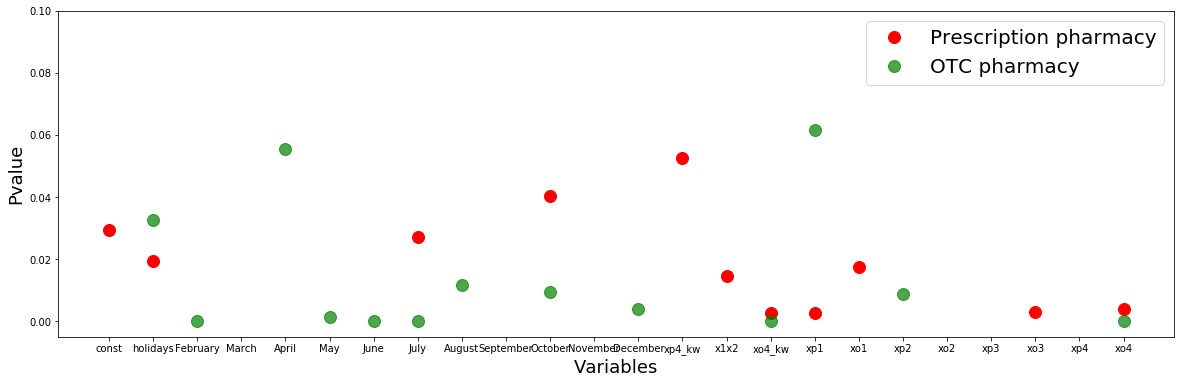

Liczba usunietych zmiennych: 24


In [38]:
model_reduced = VAR(y1 = yp[:100], X1 = X2[:100,], y2 = yo[:100], X2 = X2[:100,], T = 100,
                              colnames1 = v_names.copy(), colnames2 = v_names.copy())
b_hat3, var_b3, sigma3, pvalues = model_reduced.reduction(criterion = 0.1, 
                                                          save_plot_as = figure_path + "reduced_model_01.png")

In [39]:
max(pvalues)

0.0616685221237554

In [40]:
from scipy.stats.distributions import chi2


def lr_test(l0, l1, df):
    loglikelihood_ratio = 2 * abs(llm0 - llm1)
    return 1 - chi2.cdf(loglikelihood_ratio, df)


llm0 = model_reduced.llf(b_hat3, sigma3)
llm1 = model.llf(b_hat2, sigma2)
print("model reduced:", round(llm0,3), "\nfull model:", round(llm1,3))

#llf ratio test
#H0: we should reduce the model
df = len(b_hat2) - len(b_hat3)
loglikelihood_ratio = 2 * abs(llm0 - llm1)
lr_test(llm0, llm1, df)

model reduced: -586.681 
full model: -579.471


0.9365767825741363

Usuwamy "const" pvalue = 0.97 (OTC)
Usuwamy "xo2" pvalue = 0.94 (Prescription)
Usuwamy "xo1" pvalue = 0.92 (OTC)
Usuwamy "November" pvalue = 0.76 (OTC)
Usuwamy "April" pvalue = 0.77 (Prescription)
Usuwamy "xp3" pvalue = 0.7 (OTC)
Usuwamy "xp4" pvalue = 0.55 (Prescription)
Usuwamy "x1x2" pvalue = 0.58 (OTC)
Usuwamy "September" pvalue = 0.44 (OTC)
Usuwamy "xo3" pvalue = 0.52 (OTC)
Usuwamy "March" pvalue = 0.59 (OTC)
Usuwamy "March" pvalue = 0.48 (Prescription)
Usuwamy "September" pvalue = 0.4 (Prescription)
Usuwamy "August" pvalue = 0.48 (Prescription)
Usuwamy "November" pvalue = 0.46 (Prescription)
Usuwamy "May" pvalue = 0.54 (Prescription)
Usuwamy "xp4" pvalue = 0.4 (OTC)
Usuwamy "xp3" pvalue = 0.36 (Prescription)
Usuwamy "February" pvalue = 0.37 (Prescription)
Usuwamy "xp2" pvalue = 0.33 (Prescription)
Usuwamy "December" pvalue = 0.24 (Prescription)
Usuwamy "June" pvalue = 0.21 (Prescription)
Usuwamy "xp4_kw" pvalue = 0.17 (OTC)
Usuwamy "xo2" pvalue = 0.27 (OTC)
Usuwamy "xp1" pvalue =

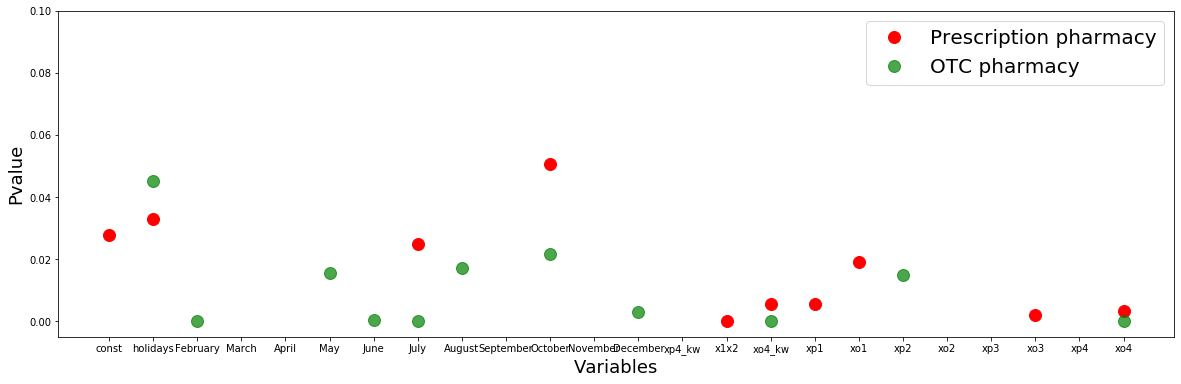

Liczba usunietych zmiennych: 27


In [41]:
model_reduced2 = VAR(y1 = yp[:100], X1 = X2[:100,], y2 = yo[:100], X2 = X2[:100,], T = 100,
                              colnames1 = v_names.copy(), colnames2 = v_names.copy())
b_hat4, var_b4, sigma4, pvalues = model_reduced2.reduction(criterion = 0.051, 
                                                          save_plot_as = figure_path + "reduced_model_02.png")

In [42]:
max(pvalues)

0.050819527634693884

In [43]:
llm0 = model_reduced2.llf(b_hat4, sigma4)
llm1 = model.llf(b_hat2, sigma2)
df = len(b_hat2) - len(b_hat4)
print("model reduced:", round(llm0,3), "\nfull model:", round(llm1,3))

#llf ratio test
#H0: we should reduce the model
lr_test(llm0, llm1, df)

model reduced: -591.919 
full model: -579.471


0.5802509213968076

In [44]:
t_stat4, pvalues4 = model_reduced2.variables_importance(b_hat4 ,var_b4)

# dataframe for storing coefficients of prescription pharmacy equation
Zellner_df_pre4 = pd.DataFrame()
Zellner_df_pre4["variable_name"] = model_reduced2.colnames1
Zellner_df_pre4["coefs"] = b_hat4[:len(model_reduced2.colnames1)]
Zellner_df_pre4["std. error"] =   [var_b4[i,i]**0.5 for i in range(len(model_reduced2.colnames1))]
Zellner_df_pre4["t_stat"] = t_stat4[:len(model_reduced2.colnames1)]
Zellner_df_pre4["pvalues"] = pvalues4[:len(model_reduced2.colnames1)]


# dataframe for storing coefficients of prescription pharmacy equation
Zellner_df_otc4 = pd.DataFrame()
Zellner_df_otc4["variable_name"] = model_reduced2.colnames2
Zellner_df_otc4["coefs"] = b_hat4[len(model_reduced2.colnames1):]
Zellner_df_otc4["std. error"] = [var_b4[i,i]**0.5 for i in range(len(model_reduced2.colnames1),
                                        len(model_reduced2.colnames1 + model_reduced2.colnames2))]
Zellner_df_otc4["t_stat"] = t_stat4[len(model_reduced2.colnames1):]
Zellner_df_otc4["pvalues"] = pvalues4[len(model_reduced2.colnames1):]

In [45]:
print(Zellner_df_pre4.to_latex(float_format="{:0.4f}".format))

\begin{tabular}{llrrrr}
\toprule
{} & variable\_name &     coefs &  std. error &  t\_stat &  pvalues \\
\midrule
0 &         const & -305.0771 &    136.1433 & -2.2409 &   0.0278 \\
1 &      holidays &   -8.4991 &      3.9182 & -2.1691 &   0.0331 \\
2 &          July &   -7.9266 &      3.4644 & -2.2880 &   0.0248 \\
3 &       October &   -6.6816 &      3.3691 & -1.9832 &   0.0508 \\
4 &          x1x2 &    0.0051 &      0.0013 &  3.9934 &   0.0001 \\
5 &        xo4\_kw &   -0.1122 &      0.0393 & -2.8547 &   0.0055 \\
6 &           xp1 &    0.2215 &      0.0775 &  2.8583 &   0.0054 \\
7 &           xo1 &   -0.7647 &      0.3196 & -2.3924 &   0.0191 \\
8 &           xo3 &   -0.8834 &      0.2788 & -3.1688 &   0.0022 \\
9 &           xo4 &   14.1464 &      4.6797 &  3.0229 &   0.0034 \\
\bottomrule
\end{tabular}



In [46]:
#rolling window
training_len = 104
obs_left = 39

#pandas data frame (for forecasting) and easy acess to left colnames
Xpd = pd.DataFrame(X2, columns = v_names)

#pandas dataframe for storing the resulting forecasts
y_hat = pd.DataFrame({"Prescription Pharmacy":np.zeros(obs_left), "OTC Pharmacy":np.zeros(obs_left)})
modelf = VAR(y1 = yp[:100], X1 = X2[:100,], y2 = yo[:100], X2 = X2[:100,], T = 100,
                              colnames1 = v_names.copy(), colnames2 = v_names.copy())
b_hat, var_b, sigma, pvalues = modelf.reduction(criterion = 0.051, plot = False)

len_var1 = len(modelf.colnames1)
len_var2 = len(modelf.colnames2)
for i in range(1, obs_left + 1):
    # 1-point forecast for prescriription pharmacy
    y_hat.iloc[i-1, 0] = Xpd[list(modelf.colnames1)].iloc[100+i-1,:] @ b_hat[:modelf.X1.shape[1]]
    # 1-point forecast for OTC pharmacy
    y_hat.iloc[i-1, 1] = Xpd[list(modelf.colnames2)].iloc[100+i-1,:] @ b_hat[modelf.X1.shape[1]:]
    
    #reestimate the model
    modelf = VAR(y1 = yp[:100+i], X1 = Xpd[list(modelf.colnames1)].iloc[:100+i,].to_numpy(),
                                  y2 = yo[:100+i], X2 = Xpd[list(modelf.colnames2)].iloc[:100+i,].to_numpy()
                                  ,T = 100+i, colnames1 = modelf.colnames1, colnames2 = modelf.colnames2)
    sigma = modelf.Simple_sigma_est()
    b_hat, var_b = modelf.Zellner_fit(sigma)

Usuwamy "const" pvalue = 0.97 (OTC)
Usuwamy "xo2" pvalue = 0.94 (Prescription)
Usuwamy "xo1" pvalue = 0.92 (OTC)
Usuwamy "November" pvalue = 0.76 (OTC)
Usuwamy "April" pvalue = 0.77 (Prescription)
Usuwamy "xp3" pvalue = 0.7 (OTC)
Usuwamy "xp4" pvalue = 0.55 (Prescription)
Usuwamy "x1x2" pvalue = 0.58 (OTC)
Usuwamy "September" pvalue = 0.44 (OTC)
Usuwamy "xo3" pvalue = 0.52 (OTC)
Usuwamy "March" pvalue = 0.59 (OTC)
Usuwamy "March" pvalue = 0.48 (Prescription)
Usuwamy "September" pvalue = 0.4 (Prescription)
Usuwamy "August" pvalue = 0.48 (Prescription)
Usuwamy "November" pvalue = 0.46 (Prescription)
Usuwamy "May" pvalue = 0.54 (Prescription)
Usuwamy "xp4" pvalue = 0.4 (OTC)
Usuwamy "xp3" pvalue = 0.36 (Prescription)
Usuwamy "February" pvalue = 0.37 (Prescription)
Usuwamy "xp2" pvalue = 0.33 (Prescription)
Usuwamy "December" pvalue = 0.24 (Prescription)
Usuwamy "June" pvalue = 0.21 (Prescription)
Usuwamy "xp4_kw" pvalue = 0.17 (OTC)
Usuwamy "xo2" pvalue = 0.27 (OTC)
Usuwamy "xp1" pvalue =

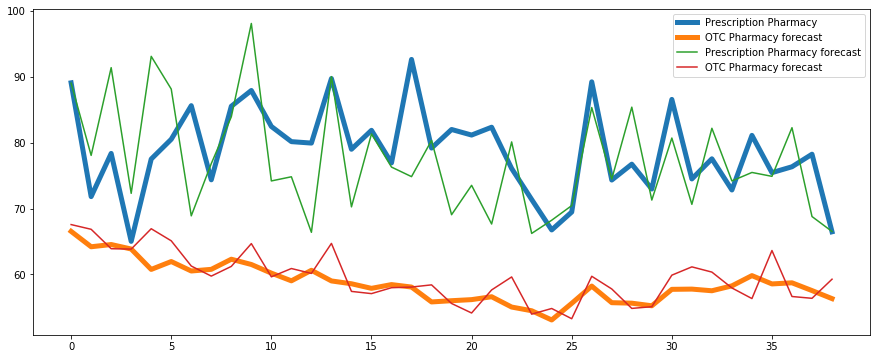

In [47]:
plt.figure(figsize = (15,6))
plt.plot(y_hat, lw = 5)
plt.plot(yp[100:])
plt.plot(yo[100:])
plt.legend(["Prescription Pharmacy", "OTC Pharmacy forecast",
            "Prescription Pharmacy forecast", "OTC Pharmacy forecast"])
plt.savefig(figure_path + "rolling_window_reduced_model.png")
plt.show()

In [48]:
residuals = y_hat.values - endog_test.values

# Relative MAE
rel_mae = np.mean(np.abs(residuals) / endog_test.values, axis = 0)
# MSE
mse = np.mean((residuals) ** 2, axis = 0)
# MAE
mae = np.mean(np.abs(residuals), axis = 0)
# Relative MSE
rel_mse = np.mean(((residuals) / endog_test.values) ** 2, axis = 0)

In [49]:
rel_mae, rel_mse, mae, mse


(array([0.07936514, 0.03126414]),
 array([0.01106032, 0.00156858]),
 array([6.04315148, 1.89446642]),
 array([62.52589191,  5.98243661]))

## Model diagnostics

In [50]:
def residuals_analysis(residuals1, residuals2):
    plt.figure(figsize = (20,8))
    stats.probplot(residuals1, dist="norm", plot=plt.subplot(121))
    plt.title("Prescription Pharmacy", size = 25)
    stats.probplot(residuals2, dist="norm", plot=plt.subplot(122))
    plt.title("OTC Pharmacy", size = 25)
    plt.show()
    
    plt.figure(figsize = (20,18))
    plt.subplot(221)
    plt.plot(residuals1, ".", markersize = 20)
    plt.axhline(0, color = "red", lw = 3)
    plt.legend(labels = ["residuals"], fontsize = 16, facecolor = 'lightgreen', framealpha=0.5)
    plt.title("Prescription Pharmacy", size = 25)
    plt.subplot(222)
    plt.plot(residuals2, ".", markersize = 20)
    plt.axhline(0, color = "red", lw = 3)
    plt.legend(labels = ["residuals"], fontsize = 16, facecolor = 'lightgreen', framealpha=0.5)
    plt.title("OTC Pharmacy", size = 25)
    plt.subplot(223)
    sns.distplot(residuals1, bins = 20)
    plt.title("Prescription Pharmacy", size = 25)
    plt.subplot(224)
    sns.distplot(residuals2, bins = 20)
    plt.title("OTC Pharmacy", size = 25)
    plt.show()
    
from statsmodels.stats.diagnostic import acorr_ljungbox

def stat_tests_resid(residuals1, residuals2):
    print("Prescription Pharmacy, H0: data comes from normal distribution")
    print("shapiro pvalue =", stats.shapiro(residuals1)[1])
    print("omnibus pvalue =", stats.normaltest(residuals1)[1])
    print("OTC Pharmacy, H0: data comes from normal distribution")
    print("shapiro pvalue =", stats.shapiro(residuals2)[1])
    print("omnibus pvalue =", stats.normaltest(residuals2)[1])
    print("Ljung-Box test, H0: Autocerrelation is equal to 0")
    print("Prescription Pharmacy pvalue =", acorr_ljungbox(residuals1, lags = 5, return_df = False)[1])
    print("OTC Pharmacy pvalue =", acorr_ljungbox(residuals2, lags = 5, return_df = False)[1])


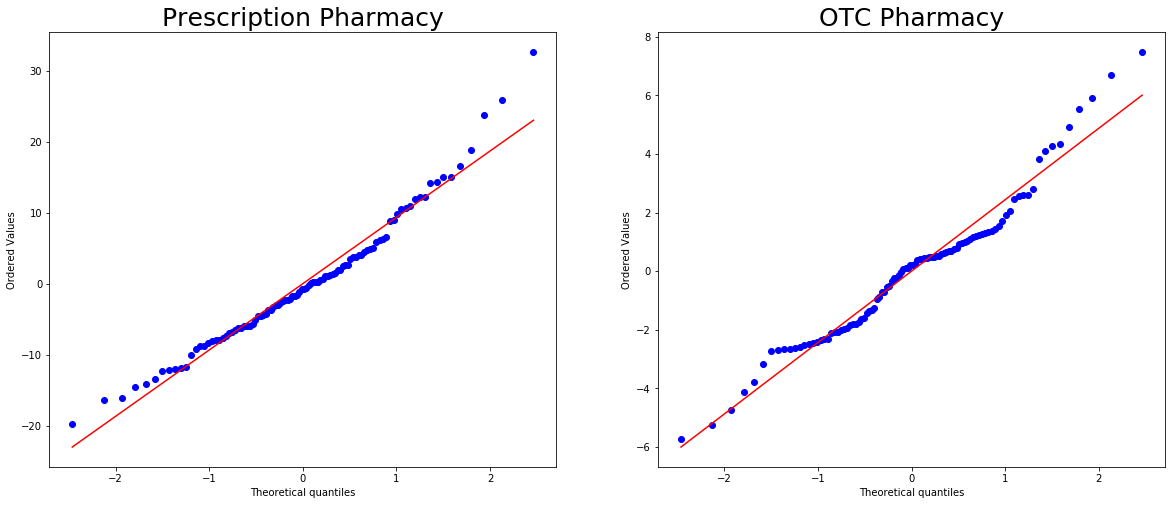

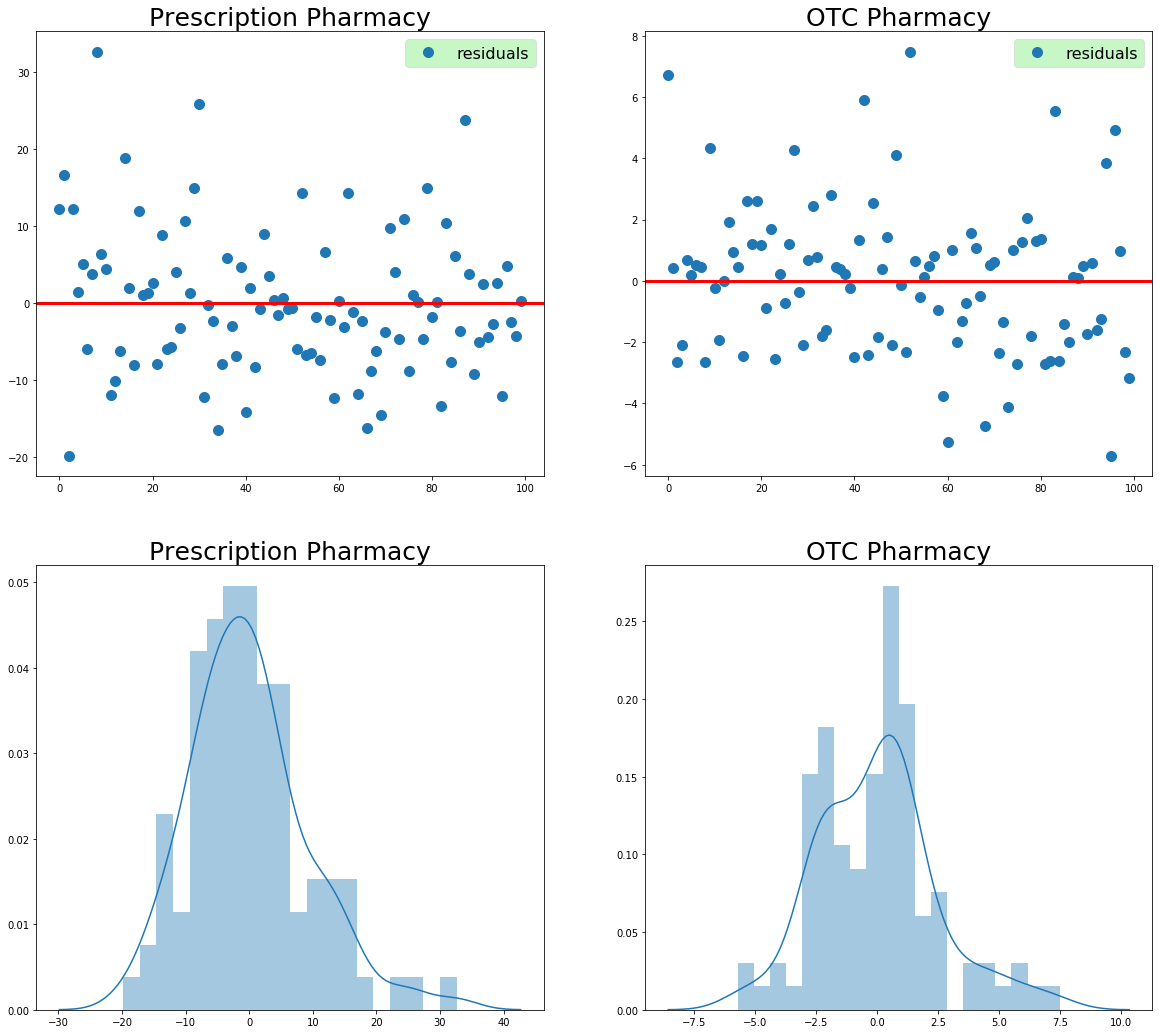

Prescription Pharmacy, H0: data comes from normal distribution
shapiro pvalue = 0.015856431797146797
omnibus pvalue = 0.0021849921659828375
OTC Pharmacy, H0: data comes from normal distribution
shapiro pvalue = 0.013083088211715221
omnibus pvalue = 0.030530141122898542
Ljung-Box test, H0: Autocerrelation is equal to 0
Prescription Pharmacy pvalue = [0.49119381 0.78817471 0.9181642  0.79229401 0.88189768]
OTC Pharmacy pvalue = [0.0826441  0.10602865 0.16772685 0.28153446 0.21818278]


In [52]:
res, y_hat0 = model_reduced2.residuals(b_hat4)
res1 = res[:model_reduced2.T]
res2 = res[model_reduced2.T:]
residuals_analysis(res1, res2)
stat_tests_resid(res1, res2)
